In [5]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch_geometric.data import Data
from MVC_env import MVC_environement
from DQN_network import Agent
import networkx as nx
from utils import mvc_bb , validation_graph_gen , get_lap_torch , density_to_edge_ba
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable

from collections import namedtuple
from copy import deepcopy
from torch_geometric.nn import dense_diff_pool 
from GCN import GCN_network
#from graph_generator import graph_generation_network , graph_generation_network_MLP
from network_result_collector import Trainer
from torch.distributions import Categorical , Normal
from collections import namedtuple
#np.random.seed(19960214)
#random.seed(19960214)
#torch.cuda.manual_seed_all(19960214)
#torch.manual_seed(19960214)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
m = torch.distributions.categorical.Categorical(probs = torch.Tensor([0.3,0.7]))
m.sample()

tensor(1)

In [62]:
all_graphs = []
for i in range(10):
    g = nx.erdos_renyi_graph(n=20 , p = .2)
    all_graphs.append(g)
train_g = all_graphs[0]
test_gs = all_graphs[1:]

In [13]:
device = 'cuda:1'
gen_net = graph_generation_network_MLP(device=device).type(torch.DoubleTensor).to(device)
graph_lap = get_lap_torch(train_g).to(device)
gen_net(graph_lap)

tensor([[0.5188]], device='cuda:1', dtype=torch.float64,
       grad_fn=<SigmoidBackward>)

In [7]:
agent = Agent(PG = True)
g = nx.erdos_renyi_graph(n = 20 , p = .2)
env = MVC_environement(g)
Xv , graph = env.reset_env()
MAX_EPISODE = 3001
val_res = []
for e in tqdm(range(MAX_EPISODE)):
    
    
    if e > 0 and e % 100 == 0:
        val_res.append(agent.get_val_result(test_gs))
    
    for _ in range(32):
        g = nx.erdos_renyi_graph(n=20 , p = .2)
        env = MVC_environement(g)
        Xv , graph = env.reset_env()
        graph = torch.unsqueeze(graph,  0)
        done = False
        agent.new_epsiode()
        while done == False:
            action = agent.take_action(graph , Xv)
            Xv_next , reward , done = env.take_action(action)
            agent.rewards.append(reward)
            agent.dones.append(done)
        agent.train()

KeyboardInterrupt: 

In [80]:
agent = Agent(global_net=True)
agent(graph , Xv)

torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 20, 192])


tensor([[-0.3382, -0.3382, -0.3382, -0.3382, -0.3382, -0.3382, -0.3382, -0.3382,
         -0.3382, -0.3382, -0.3382, -0.3382, -0.3382, -0.3382, -0.3382, -0.3382,
         -0.3382, -0.3382, -0.3382, -0.3382]], device='cuda:0',
       dtype=torch.float64, grad_fn=<SqueezeBackward1>)

[-6, -5, -4, -3, -2, -1]
tensor([-2.9957, -2.9957, -2.9957, -2.9957, -2.9957, -2.9957], device='cuda:0') tensor([-1.3363, -0.8018, -0.2673,  0.2673,  0.8018,  1.3363], device='cuda:0')
tensor(-2.0862e-06, device='cuda:0')


In [63]:
device = 'cuda:0'
g = train_g
#env = MVC_environement(g)
#Xv , graph = env.reset_env()
graph_lap = get_lap_torch(g)
graph_lap = graph_lap.to(device)
gen_net = graph_generation_network_MLP(device=device).type(torch.DoubleTensor).to(device)

optimizer = torch.optim.Adam(gen_net.parameters() , lr = 0.01)

SAR = namedtuple('SAR',['state','action','reward'])

type_list = ['er' , 'ba']

num_eps = 100
num_batch = 32
tmp_plot = []
reward_plot = []
for i in range(num_eps):
    trainer = Trainer()
    pred_density = gen_net(graph_lap)
    print(pred_density.item())
    tmp_plot.append(pred_density.item())
    m = Normal(pred_density , torch.tensor([0.1]).to(device))
    SAR_list = []
    rr =[]
    for _ in tqdm(range(num_batch)):
        cur_density = m.sample()
        cur_density = torch.clamp(cur_density , 0.05 , 0.99).item()
        g = nx.erdos_renyi_graph(n = 20 , p = 0.2)
        bef , aft = trainer.train_and_report_improvement(g , test_gs)
        reward = bef - aft
        rr.append(reward)
        sar = SAR(graph_lap , cur_density , reward)
        SAR_list.append(sar)
    reward_plot.append(sum(rr)/len(rr))
    loss = 0.0
    for sar in SAR_list:
        cur_state = sar.state
        cur_action = sar.action
        cur_reward = sar.reward
        pred_density = gen_net(cur_state)
        m = Normal(pred_density , torch.tensor([0.1]).to(device))
        loss += -m.log_prob(cur_action)*cur_reward
    #loss /= num_batch
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0.5146662429620827



0.5189146898302198



0.5222481456432648



0.5259708853796264



0.5297614278414463



0.5313265570694379



0.5301622536632993



0.5292387123741222



0.5282536591577729



0.5284886387277529



0.5268357776247645



0.5252800281194995



0.5240663329562795



0.5230459016072043



0.5220589515438779



0.5220826139044588



0.522297564420565



0.5221744184974494



0.5219819165024041



0.521850809820342



0.5218108197651178



0.5218945278796058



0.5219048659929603



0.5234009788775578



0.524830427684051



0.5261342739200725



0.5276339469453623



0.5289840055475704



0.5308504842104879



0.5328469678415138



0.5347191071225011



0.5365867361291188



0.5387516401634422



0.5406027569249219



0.5421671408818518



0.5416832181744125



0.541219495906017



0.5408951665782769



0.5409137048488896



0.5410139306937398



0.5410958028764111



0.5397251105970211



0.5383561156192664



0.5371741638341605



0.5357753763120103



0.5348656482602955



0.5338829823891253



0.5330552017207767



0.5322718388431108



0.5315130088959996



0.5308102239585006



0.5301343205516675



0.5295217740741701



0.5286615740495153



0.5279315634317625



0.527110561224362



0.5263009693923615



0.5252782866153606



0.5243621757945246



0.5235341660438095



0.5225612030560499



0.521693327764514



0.5210483266095981



0.5205055193489544



0.5200730960733947



0.5197011350248462



0.5192150743503712



0.5186317920409089



0.5181681264718733



0.5177264011320124



0.5172776489186393



0.5169403973555705



0.5165545173105659



0.5163534197249473



0.5180428466926107



0.5196091953694877



0.5211144218702388



0.5231278892805595



0.5248015591294121



0.5255747825573722



0.5262916844350312



0.5270985363812496



0.5277749905935222



0.5282396759595984



0.5286982188508349



0.5290871174462836



0.5296047114695879



0.5301473779567292



0.530547924136398



0.5304775520119731



0.5302136512869691



0.5300820367033163



0.5296054554875818



0.5298190450082045



0.5300412812135961



0.5305304395503939



0.5314163308335507



0.5320651234900491



0.5325939762208033



0.5338317528594995


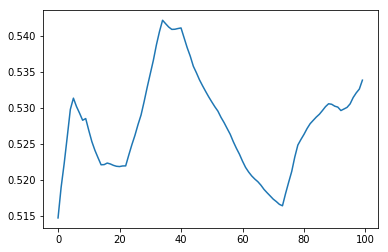

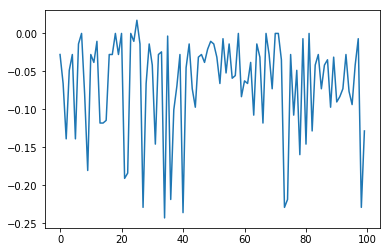

In [66]:
plt.plot(tmp_plot)
plt.show()
plt.plot(reward_plot)

In [ ]:
import os
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
graph_size_list = [50]
graph_type_list = ['er' , 'ba']
density_list = [0.15,0.3,0.5,0.7,0.8]

parameter_list = list(itertools.product(graph_size_list , graph_type_list ,density_list))
N = len(parameter_list)

VALIDATION_GRAPH_NUM = 150
performance_dict = {}
all_graphs = []
opt_results = []
for i in range(N):
    train_size = parameter_list[i][0]
    train_type = parameter_list[i][1]
    train_density = parameter_list[i][2]
    
    train_graphs = validation_graph_gen(n = train_size , p = train_density 
                                        , num = VALIDATION_GRAPH_NUM , graph_type=train_type)
    all_graphs.append(train_graphs)

for i in range(N):
    
    cur_res = []
    
    for j in tqdm(range(VALIDATION_GRAPH_NUM)):
        cur_g = all_graphs[i][j]
        C = mvc_bb(cur_g , len(cur_g.nodes()) , [])
        cur_res.append(len(C))
    opt_results.append(sum(cur_res)/len(cur_res))
    
    
